# Field Validation

In [2]:

import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [4]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')
df.shape

(2686, 103)

In [5]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Extract features (remove curb_scene, start_time, and end_time columns)
x_test = test_data_scaled.iloc[:, :-3]
y_true = test_data_scaled['curb_scene'].values
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)



In [8]:
def evaluate_classification(y_true, y_pred):
    """
    Evaluate binary classification results and display metrics and visualizations
    
    Parameters:
        y_true (array-like): Ground truth labels
        y_pred (array-like): Predicted labels
        
    Returns:
        dict: Dictionary containing the metrics (confusion matrix, accuracy, specificity, sensitivity)
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Generate detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Calculate additional metrics
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
    
    print("\nAdditional Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Specificity: {specificity:.3f}")  
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add text annotations
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'specificity': specificity,
        'sensitivity': sensitivity
    }


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2427
           1       0.49      0.83      0.61       259

    accuracy                           0.90      2686
   macro avg       0.73      0.87      0.78      2686
weighted avg       0.93      0.90      0.91      2686


Additional Metrics:
Accuracy: 0.899
Specificity: 0.906
Sensitivity (Recall): 0.834


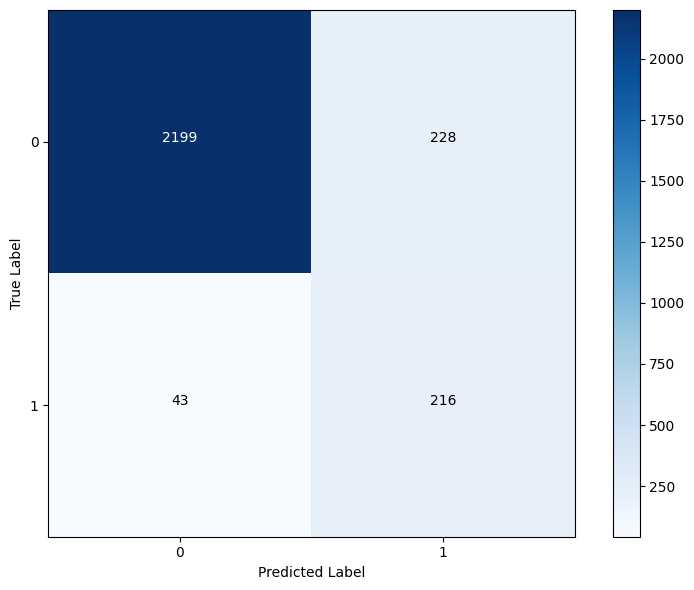

In [7]:
# Make predictions using one-class SVM
one_class_svm = joblib.load('../../models/ocsvm_best.joblib')
y_pred = one_class_svm.predict(x_test)
# Convert predictions to binary (1 for anomaly, 0 for normal)
y_pred = np.where(y_pred == -1, 1, 0)
# Evaluate results
metrics = evaluate_classification(y_true, y_pred)

